# Train a PyTorch Classifier
In this notebook we will train a binary classifier to detect plagiarism using a [dataset created by researchers at the University of Sheffield](udacity/Solutions/1_Data_Exploration.ipynb) in which plagiarism has been simulated

In the [Feature Engineering](udacity/Solutions/2_Plagiarism_Feature_Engineering.ipynb) stage I used two similarity metrics to compare the student answers to the Wikepedia source text.

1. [Containment](https://youtu.be/FwmT_7fICn0) - How many n-grams do the answer and source text have in common. Useful for detecting copy-paste style plagiarism. 
2. [Longest Commmon Subsequence](https://youtu.be/yxXXwBKeYvU) - The longest sequence of words that appear left to right in both texts. The words don't have to be exactly continuous. Useful for detecting plagiarism that uses paraphrasing.

Rather than go through feature engineering again we will load in the feature matrices produced earlier. We'll explore this data then build, validate and save a PyTorch binary classifier which will [later be used to detect plagiarism in Medium articles](notebooks/2_results.ipynb)

Lets get started.

# Initialise

In [1]:
import sys
sys.path.insert(1, '../') 

# where to save torch model output
MODEL_DIR = '../model'

## Load Data
Lets load in the training and test data

In [2]:
import pickle
plagiarism_data = pickle.load(open('plagiarism_data.p', 'rb'))
plagiarism_data.keys()

dict_keys(['train_x', 'train_y', 'test_x', 'test_y'])

In [3]:
# unpack data
train_x, train_y, test_x, test_y = plagiarism_data.values()

print(f"train_x has shape {train_x.shape}")
print(f"train_y has shape {train_y.shape}")
print(f"test_x has shape {test_x.shape}")
print(f"test_y has shape {test_y.shape}")

train_x has shape (70, 2)
train_y has shape (70,)
test_x has shape (25, 2)
test_y has shape (25,)


This is quite a small dataset with only 70 training examples and 25 test examples.
There are two input features. 
1. Containment - stored in column 0
2. Longest Common Subsequence - stored in column 1

# Visualise Training Data
Visualising our training data may give an indication as to the relationship between the inputs and the targets, and guide us to the level of non-linearity present in the data.

## Longest Common Sequence
We'll plot longest common sequence on the horizontal axis and plagiarism (yes/no) on the y axis. We would expect that higher values be associated with plagiarism.

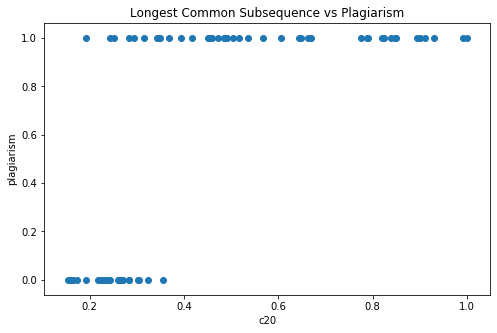

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize = (8, 5))
plt.scatter(train_x[:,1], train_y)
plt.title('Longest Common Subsequence vs Plagiarism')
plt.xlabel('c20')
plt.ylabel('plagiarism')
plt.show()

Every answer with a longest common subsequence greater than 0.38 contains plagiarism.

## Containment
Next we'll plot containment (with an ngram choice of 20) on the horizontal axis and plagiarism (yes/no) on the y axis. We would expect that higher values be associated with plagiarism.

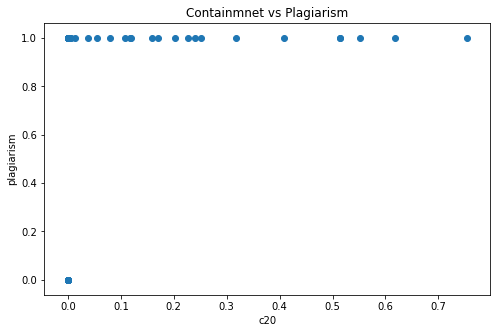

In [5]:
plt.figure(figsize = (8, 5))
plt.scatter(train_x[:,0], train_y)
plt.title('Containmnet vs Plagiarism')
plt.xlabel('c20')
plt.ylabel('plagiarism')
plt.show()

Containmnet looks to be a much better predictor of plagiarism, with everything above 0 indicating plagiarism

## Two Way Scatter Plot
Now lets plot containmnet and longest common subsequence together in a scatter plot, and label the points as plagiarised (yes/no).

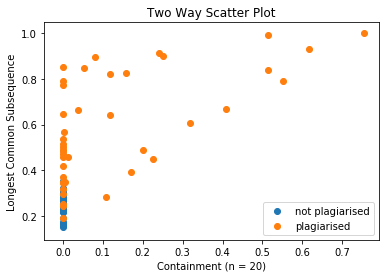

In [6]:
import numpy as np

label_dict = {0:'not plagiarised', 1:'plagiarised'}

fig, ax = plt.subplots()
for is_plagiarism in np.unique(train_y):
    ix = np.where(train_y == is_plagiarism)
    ax.scatter(train_x[ix,0], train_x[ix,1], label = label_dict[is_plagiarism])
ax.legend(loc = 4)
plt.title('Two Way Scatter Plot')
plt.xlabel('Containment (n = 20)')
plt.ylabel('Longest Common Subsequence')
plt.show()

It looks like these features complement each other nicely. Longest Common Subsequence allows us to further partition the cases where Containment is zero. We could probably produce a reasonable accurate set of classificaton rules from this chart alone, but instead we'll train a neural network to do this job for us.

# Training the Model
We are going to train a neural network to classify the students answers into plagiarised vs non-plagiarised. Although we are training a model on a small dataset, eventually we will be requesting predictions for hundreds of thousands of datapoints. This is because we will be making pairwise comparisons for all downloaded Medium articles. So before we get started with the modelling we need to choose an environment to work in.

## Amazon Sagemaker vs Vanilla PyTorch

As part of the Udacity ML Engineer Nano Degree they provided some starter code for building and deploying models using Amazon SageMaker. SageMaker allows you to deploy a range of models (sklearn, PyTorch etc) as a Rest API so that it can be consumed via a web app or similar. There is an overhead that comes with this - training model can be a bit tedious since every time you train a model seperate infrastructure needs to be provisionsed. Additionally when you come to deploy the model through the API endpoint there are costs associated with this. Our usecase is simply exploratory in nature - we are not looking to deploy our model. Therefore Amazon Sagemaker is overkill. Instead we'll write a basic classifier ourselves using vanilla PyTorch.

## PyTorch Data Loaders
We tend to train pytorch models in batches. In order to do this we need to create a data loader

In [7]:
import torch.utils.data

# Turn the numpy arrays into tensors
train_x = torch.from_numpy(train_x).float()
train_y = torch.from_numpy(train_y).float().squeeze()

# build the torch dataset
train_ds = torch.utils.data.TensorDataset(train_x, train_y)

# build the data loaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size = 10)

Next we specify our train function. Usually to avoid overfitting we would use a validaiton sample and stop training once the validation error no longer decreases. However in our case we only have 70 training examples and therefore we'll train until the training error reaches a plateu. There is a risk here of overfitting - and we'll guard against it in two ways
1. Plot the classification boundary to check what the classifier is going
2. Limit the number of peeks at the test data, and use that as an independent check of classifier performance.

In [8]:
def train(model, train_loader, epochs, optimizer, criterion, device):
    
    for epoch in range(1, epochs + 1):
        # monitor training loss
        train_loss_total = 0
        
        ######################
        # train the model    #
        ######################
        model.train() # prep model for training
        
        for data, target in train_loader:
            target = target.contiguous().view(-1, 1)
            
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad() # zero accumulated gradients
            output = model(data) # make a forward pass
            loss = criterion(output, target)
            loss.backward() # make a backward pass
            optimizer.step()
            
            train_loss_total += loss.item()
            
        # calculate average loss over an epoch
        train_loss = train_loss_total / len(train_loader)
        
        # print loss statistics
        print(f"Epoch: {epoch}, train_loss: {train_loss}")

We define a pytorch model class called BinaryClassifer and a predict function which we store in a file for later use

In [9]:
from src.utils.model import BinaryClassifier, predict
!pygmentize '../src/utils/model.py'

# torch imports
import torch.nn.functional as F
import torch.nn as nn
import torch

def predict(input_data, model):
    '''
    Produce model predictions for some input_data using a saved PyTorch model

    Arguments:
        input_data (numpy matrix)
        model (PyTorch model)
    
    Returns:
        numpy array of model predictions
    '''
    print('Predicting class probabilities for the input data...')

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Process input_data so that it is ready to be sent to our model.
    data = torch.from_numpy(input_data.astype('float32'))
    data = data.to(device)

    # Put the model into evaluation mode
    model.eval()

    # Predicted scores
    probabilities = model(data).cpu().detach().numpy()

    return probabilities

class BinaryClassifier(nn.Module):
    """
    Define a neural network that performs binary classification.
    The network should accept your number of features as input, and produce 


Next we train our model. A small number of layers is chosen since our input dimension is small.

In [10]:
import torch.optim as optim

input_features = 2
hidden_dim = 7
output_dim = 1
learning_rate = 0.001
epochs = 300

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BinaryClassifier(input_features, hidden_dim, output_dim)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
loss_fn = torch.nn.BCELoss()

train(model, train_dl, epochs, optimizer, loss_fn, device)

Epoch: 1, train_loss: 0.7066477366856166
Epoch: 2, train_loss: 0.7075955016272408
Epoch: 3, train_loss: 0.7036196163722447
Epoch: 4, train_loss: 0.7022808960505894
Epoch: 5, train_loss: 0.7039280704089573
Epoch: 6, train_loss: 0.7012208444731576
Epoch: 7, train_loss: 0.6994143554142543
Epoch: 8, train_loss: 0.7002227987561908
Epoch: 9, train_loss: 0.6986893330301557
Epoch: 10, train_loss: 0.6963434049061367
Epoch: 11, train_loss: 0.6967335428510394
Epoch: 12, train_loss: 0.6963287081037249
Epoch: 13, train_loss: 0.694948537009103
Epoch: 14, train_loss: 0.6930008445467267
Epoch: 15, train_loss: 0.6937265566417149
Epoch: 16, train_loss: 0.6929550426346915
Epoch: 17, train_loss: 0.6926676801272801
Epoch: 18, train_loss: 0.6898664917264666
Epoch: 19, train_loss: 0.6890133449009487
Epoch: 20, train_loss: 0.6885411994797843
Epoch: 21, train_loss: 0.6878343309674945
Epoch: 22, train_loss: 0.688482906137194
Epoch: 23, train_loss: 0.6875549895422799
Epoch: 24, train_loss: 0.6858681184904916
Epo

Epoch: 208, train_loss: 0.5412098126752036
Epoch: 209, train_loss: 0.5474626209054675
Epoch: 210, train_loss: 0.579317991222654
Epoch: 211, train_loss: 0.568027023758207
Epoch: 212, train_loss: 0.49963065556117464
Epoch: 213, train_loss: 0.5204983694212777
Epoch: 214, train_loss: 0.5319481832640511
Epoch: 215, train_loss: 0.5017608531883785
Epoch: 216, train_loss: 0.5391326631818499
Epoch: 217, train_loss: 0.5230586443628583
Epoch: 218, train_loss: 0.5274069394384112
Epoch: 219, train_loss: 0.48301070077078684
Epoch: 220, train_loss: 0.5077752854142871
Epoch: 221, train_loss: 0.521927569593702
Epoch: 222, train_loss: 0.4932613968849182
Epoch: 223, train_loss: 0.5278824865818024
Epoch: 224, train_loss: 0.5297253131866455
Epoch: 225, train_loss: 0.5014594282422747
Epoch: 226, train_loss: 0.5177151688507625
Epoch: 227, train_loss: 0.4770152909415109
Epoch: 228, train_loss: 0.527503605399813
Epoch: 229, train_loss: 0.4857472649642399
Epoch: 230, train_loss: 0.5228347906044551
Epoch: 231, t

# Predict Test Data and Evaluate Classifier
Now we'll predict the test data and convert the predictions to a binary classification

In [11]:
probabilities = predict(test_x, model)
labels = probabilities.round()

Predicting class probabilities for the input data...


To evaluate the model we'll use the helper function provided by Udacity

In [12]:
# returns a variety of model metrics
import pandas as pd
import numpy as np

def evaluate(test_preds, test_labels, verbose=True):
    """
    Evaluate a model on a test set given the prediction endpoint.  
    Return binary classification metrics.
    :param predictor: A prediction endpoint
    :param test_features: Test features
    :param test_labels: Class labels for test data
    :param verbose: If True, prints a table of all performance metrics
    :return: A dictionary of performance metrics.
    """
    test_preds = np.squeeze(test_preds)
    
    # calculate true positives, false positives, true negatives, false negatives
    tp = np.logical_and(test_labels, test_preds).sum()
    fp = np.logical_and(1-test_labels, test_preds).sum()
    tn = np.logical_and(1-test_labels, 1-test_preds).sum()
    fn = np.logical_and(test_labels, 1-test_preds).sum()
    
    # calculate binary classification metrics
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    
    # print metrics
    if verbose:
        print(pd.crosstab(test_labels, test_preds, rownames=['actuals'], colnames=['predictions']))
        print("\n{:<11} {:.3f}".format('Recall:', recall))
        print("{:<11} {:.3f}".format('Precision:', precision))
        print("{:<11} {:.3f}".format('Accuracy:', accuracy))
        print()
        
    return {'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn, 
            'Precision': precision, 'Recall': recall, 'Accuracy': accuracy}

In [13]:
metrics = evaluate(labels, test_y)

predictions  0.0  1.0
actuals              
0              9    1
1              0   15

Recall:     1.000
Precision:  0.938
Accuracy:   0.960



That is a pretty good model!

# Classification Boundary
With a little help from the [scikit-learn documentation](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)
we will display the classification boundary for our neural net.

In [14]:
# unpack data again
train_x, train_y, test_x, test_y = plagiarism_data.values()

In [15]:
h = 0.02 # step size in the mesh

xx, yy = np.meshgrid(np.arange(0, 1, h),
                    np.arange(0, 1, h))

In [16]:
Z = predict(np.c_[xx.ravel(), yy.ravel()], model)
Z = Z.reshape(xx.shape)

Predicting class probabilities for the input data...


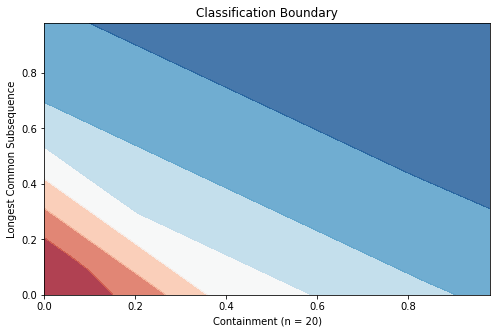

In [17]:
plt.figure(figsize = (8, 5))
cm = plt.cm.RdBu
plt.contourf(xx, yy, Z, cmap=cm, alpha=.8)
plt.title('Classification Boundary')
plt.xlabel('Containment (n = 20)')
plt.ylabel('Longest Common Subsequence')
plt.show()

Red is low probability, Blue is high. We can see that high values of the features are associated with a high probability of plagiarism. This gives us further confidence the model is behaving as expected.

# Save Model
We'll want to use this PyTorch model later to predict the Medium articles, so we save it here

In [18]:
import os

model_info_path = os.path.join(MODEL_DIR, 'model_info.pth')
with open(model_info_path, 'wb') as f:
    model_info = {
        'input_features': input_features,
        'hidden_dim': hidden_dim,
        'output_dim': output_dim,
    }
    torch.save(model_info, f)
  
# Save the model parameters
model_path = os.path.join(MODEL_DIR, 'model.pth')
with open(model_path, 'wb') as f:
    torch.save(model.cpu().state_dict(), f)